In [1]:
import os

import ipywidgets as widgets
import numpy as np
import pandas as pd
import scipy.sparse
from IPython.display import display
from ipywidgets import interact
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import os
# alternatively, you may override the variables in oneinamillion.resources.py
os.environ['PCC_BASE_DIR'] = "Z:/"

In [3]:
from oneinamillion.resources import PCC_BASE_DIR
print(f"RDSF base directory located at {PCC_BASE_DIR}")

RDSF base directory located at Z:/


In [4]:
from oneinamillion.pc_consultation import PCConsultation

parser = PCConsultation()  # the only class needed to obtain all PC consultation data-pairs
orig_dataset = parser.get_pd()

# orig_dataset.head()  # uncomment to inspect the original dataset

The current IDs only have record documents.
['011119' '020105' '030311' '030501' '030509' '030510' '050609' '050717'
 '050719' '071010' '071201' '071202' '071203' '071204' '071205' '071206'
 '071207' '071208' '071209' '071210' '071211' '071212' '071213' '071214'
 '081310' '081608' '081610' '091410' '091411' '091416' '101705' '101707'
 '111906' '111908' '112004' '122110']
The current IDs only have transcript documents.
['-081308' '010103' '010105' '020107' '030501(p.2)' '030501(p1)'
 '030509(p.1)' '030509(p.2)' '030510 (p.1)' '030510 (p.2)' '040417'
 '050605' '050609a' '050717 (Dr reads wrong number)' '060806' '060811'
 '060812' '060906' '071002' '071010(a)' '071012' '081310(b)' '081310(c)'
 '081310a' '081601' '081606' '081608 (1 of 2)' '081608 (2 of 2)' '091402'
 '091404' '091405' '091410 & 091411' '091503' '101705 and 101707' '101801'
 '111906 (2of2)' '111906(1 of 2)' '112002' '112004 & 1112005' '112014'
 '200105' '50719']


# Data preparation

First split the orig_dataset into train and test set, then we need to
pre-process the transcript data

This includes, cleaning text, stemming and lemmatization

In [5]:
from utils.preprocessing.data import extract_icpc_categories
from utils.transcripts import preprocess_transcripts, read_transcript

orig_dataset['codes'] = orig_dataset['icpc_codes'].apply(extract_icpc_categories)
orig_dataset['transcript__conversation_clean'] = orig_dataset['transcript__conversation'].apply(preprocess_transcripts)
orig_dataset['transcript__conversation_both'] = orig_dataset['transcript__conversation_clean'].apply(
    lambda t: read_transcript(t, return_format='concat'))
orig_dataset['transcript__conversation_gp'] = orig_dataset['transcript__conversation_clean'].apply(
    lambda t: read_transcript(t, show_gp=True, show_patient=False, return_format='concat'))
orig_dataset['transcript__conversation_patient'] = orig_dataset['transcript__conversation_clean'].apply(
    lambda t: read_transcript(t, show_gp=False, show_patient=True, return_format='concat'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
orig_dataset.head()

,index,record_id,icpc_codes,pt_records,transcript__start_date,transcript__duration,transcript__conversation,codes,transcript__conversation_clean,transcript__conversation_both,transcript__conversation_gp,transcript__conversation_patient
0,0,10112,"['K85', 'P76']","[{'date': datetime.datetime(2014, 8, 13, 0, 0)...",2014-06-16 10:33:28,0:16:17,"[('GP', 'How are you sir?'), ('Patient', ""I'm ...","[K, P]","[[GP, sir?], [Patient, i'm bad moment actually...","sir? i'm bad moment actually. right, okay good...","sir? right, okay good. prednisolone. okay. yes...",i'm bad moment actually. thought i'd come touc...
1,1,50709,"['R04', 'U04']","[{'date': datetime.datetime(2015, 1, 26, 0, 0)...",2014-11-05 19:40:49,0:13:20,"[('info', 'Oh, can I 0:00:00'), ('GP', ""___. Y...","[R, U]","[[info, oh, 0:00:00], [GP, ___. 050709. give o...","___. 050709. give one back. help? well, basica...","___. 050709. give one back. help? yes. oh, cer...","well, basically, i've kind come twofold, know ..."
2,2,20208,['H82'],"[{'date': datetime.datetime(2014, 11, 3, 0, 0)...",2014-09-08 10:43:09,0:11:33,"[('Doc', 'Morning NAME.'), ('Pat', 'Hi, how yo...",[H],"[[Doc, morning name.], [Pat, hi, doing?], [Doc...","morning name. hi, doing? doing? bad. thank com...",morning name. doing? thank coming along. dr na...,"hi, doing? bad. yes. doc worry. i'll take numb..."
3,3,50601,"['K85', 'P15']","[{'date': datetime.datetime(2014, 12, 5, 0, 0)...",2014-11-05 09:27:26,0:19:21,"[('GP', ""Thank you very much for this. Right, ...","[K, P]","[[GP, thank much this. right, 050601, accordin...","thank much this. right, 050601, according this...","thank much this. right, 050601, according this...","yeah. well, couple things. first all, i'm litt..."
4,4,111915,"['D95', 'P74']","[{'date': datetime.datetime(2015, 5, 29, 0, 0)...",2015-04-28 12:17:47,0:19:41,"[('DOC', 'Thank you, what number are you on? S...","[D, P]","[[DOC, thank you, number on? sixteen. hi, doct...","thank you, number on? sixteen. hi, doctor name...","thank you, number on? sixteen. hi, doctor name...","no, don’t think met before. well, combination ..."


In [7]:
orig_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   index                             241 non-null    int64 
 1   record_id                         241 non-null    int64 
 2   icpc_codes                        241 non-null    object
 3   pt_records                        241 non-null    object
 4   transcript__start_date            241 non-null    object
 5   transcript__duration              241 non-null    object
 6   transcript__conversation          241 non-null    object
 7   codes                             241 non-null    object
 8   transcript__conversation_clean    241 non-null    object
 9   transcript__conversation_both     241 non-null    object
 10  transcript__conversation_gp       241 non-null    object
 11  transcript__conversation_patient  241 non-null    object
dtypes: int64(2), object(10

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

y = orig_dataset['codes']
mult_lbl_enc = MultiLabelBinarizer()
y_hot = mult_lbl_enc.fit_transform(y)
print(f"{len(mult_lbl_enc.classes_)} classification categories: {mult_lbl_enc.classes_}")

16 classification categories: ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']


## Train test Split

In [9]:
from skmultilearn.model_selection import iterative_train_test_split

X = np.arange(orig_dataset['index'].shape[0]).reshape((-1, 1))

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y_hot, test_size=0.2)

train_set = orig_dataset.iloc[X_train.flatten()]
test_set = orig_dataset.iloc[X_test.flatten()]
train_set.head()

,index,record_id,icpc_codes,pt_records,transcript__start_date,transcript__duration,transcript__conversation,codes,transcript__conversation_clean,transcript__conversation_both,transcript__conversation_gp,transcript__conversation_patient
0,0,10112,"['K85', 'P76']","[{'date': datetime.datetime(2014, 8, 13, 0, 0)...",2014-06-16 10:33:28,0:16:17,"[('GP', 'How are you sir?'), ('Patient', ""I'm ...","[K, P]","[[GP, sir?], [Patient, i'm bad moment actually...","sir? i'm bad moment actually. right, okay good...","sir? right, okay good. prednisolone. okay. yes...",i'm bad moment actually. thought i'd come touc...
5,5,101708,"['K84', 'Y08']","[{'date': datetime.datetime(2015, 4, 24, 0, 0)...",2015-02-24 12:39:49,0:18:49,"[('PAT', 'He was supposed to come in and take ...","[K, Y]","[[PAT, supposed come take ___], [info, 0:00:01...","supposed come take ___ , ___. yes, that's alri...","yes, that's alright you. seat. patient 101708....","supposed come take ___ , ___. okay. reason i'v..."
6,6,20212,"['L10', 'R05']","[{'date': datetime.datetime(2014, 9, 17, 0, 0)...",2014-09-08 14:24:39,0:07:58,"[('Doc', ""...you have symptoms of acid reflux,...","[L, R]","[[Doc, ...you symptom acid reflux, four week t...","...you symptom acid reflux, four week trial an...","...you symptom acid reflux, four week trial an...","acid. okay, indication acid something diet wou..."
8,8,111911,"['B80', 'D18']","[{'date': datetime.datetime(2015, 7, 21, 0, 0)...",2015-04-28 10:48:20,0:11:01,"[('DOC', 'Hi, I am Doctor Name thanks for wait...","[B, D]","[[DOC, hi, doctor name thanks waiting. doing, ...","hi, doctor name thanks waiting. doing, help? a...","hi, doctor name thanks waiting. doing, help? o...",alright thank you. last friday went give blood...
10,10,30303,"['L09', 'L15']","[{'date': datetime.datetime(2014, 12, 17, 0, 0...",2014-09-29 09:42:56,0:18:24,"[('Doc', ""-been raised for a while, actually. ...","[L, L]","[[Doc, -been raised while, actually. i've worn...","-been raised while, actually. i've worn knee o...","-been raised while, actually. i've worn knee o...","oh, no. many hill walking stuff like that. i'v..."


## ICPC descriptions

In [10]:
from oneinamillion.clinical_codes.icpc import IcpcParser

icpc_parser = IcpcParser()
icpc_df = icpc_parser.get_pd()

In [11]:
from utils.preprocessing.text import utils_preprocess_text

icpc_df['cat'] = icpc_df['Code'].astype('string').apply(lambda x: x[0].upper())

clean_col = lambda x: utils_preprocess_text(x) if not pd.isna(x) else x
# building keyword collection from three columns of the ICPC-2 descriptions
icpc_df['criteria_prepared'] = icpc_df['criteria'].apply(clean_col)
icpc_df['inclusion_prepared'] = icpc_df['inclusion'].apply(clean_col)
icpc_df['preferred_prepared'] = icpc_df['preferred'].apply(clean_col)
icpc_df['keywords'] = icpc_df[['preferred_prepared', 'criteria_prepared', 'inclusion_prepared']].fillna('').agg(
    ' '.join, axis=1)

In [12]:
icpc_description_corpus = icpc_df[['cat', 'keywords']].groupby('cat').agg(' '.join).iloc[1:-1]
icpc_description_corpus.index.name = None
#icpc_description_corpus

In [13]:
print(f"dataset categories: {np.array(mult_lbl_enc.classes_).astype('str')}")
print(f"icpc descriptions:  {np.array(icpc_description_corpus.index).astype('str')}")

dataset categories: ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']
icpc descriptions:  ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']


In [14]:
# Integrate with CKS descriptions
from oneinamillion.clinical_codes.cks import CksParser

# use from_raw to refresh cached cks descriptions, and headings_to_include to use different set of sub-sections to include
cks_parser = CksParser()
cks_description_corpus = cks_parser.get_pd()
# cks_description_corpus

,cks descriptions
A,advance anti-retroviral therapy (art) meant hi...
B,uk (and us) prevalence vitamin b12 deficiency ...
D,primary anal fissuresaround half acute primary...
F,"central visual loss common, total visual loss ..."
H,cholesteatoma tendency recur following surgica...
K,cks could find recent information prevalence a...
L,achilles tendon pathology common active people...
N,prompt adequate antimicrobial treatment suppor...
P,child attention deficit hyperactivity disorder...
R,prospective questionnaire survey child aged 3–...


In [33]:
selected_mode = None
modes = ['ICPC only', 'CKS only', 'ICPC and CKS']
def control_description(mode=modes[0]):
    global selected_mode
    selected_mode = mode

interact(control_description, mode=modes)

interactive(children=(Dropdown(description='mode', options=('ICPC only', 'CKS only', 'ICPC and CKS'), value='I…

<function __main__.control_description(mode='ICPC only')>

In [34]:
print(f"Description: {selected_mode}")
icpc_description_dic = {}
for icpc_code in mult_lbl_enc.classes_:
    icpc_code = icpc_code.upper()
    if selected_mode == 'ICPC only':
        icpc_description_dic[icpc_code] = f"{icpc_description_corpus.loc[icpc_code]['keywords']}"
    elif selected_mode == 'CKS only':
        icpc_description_dic[icpc_code] = f"{cks_description_corpus.loc[icpc_code]['cks descriptions']}"
    else:
        icpc_description_dic[icpc_code] = f"{icpc_description_corpus.loc[icpc_code]['keywords']} {cks_description_corpus.loc[icpc_code]['cks descriptions']}"

icpc_corpus_df = pd.DataFrame.from_dict(icpc_description_dic, orient='index', columns=['keyword'])
icpc_corpus = icpc_corpus_df['keyword']
icpc_corpus

Description: ICPC only


A    pain general/multiple site  chronic general pa...
B    lymph gland(s) enlarged/painful  lymphadenopat...
D    abdominal pain/cramps general  abdominal colic...
F    eye pain   red eye  bloodshot/inflamed eye eye...
H    ear pain/earache   hearing complaint  auditory...
K    heart pain  pain attributed heart pressure/tig...
L    neck symptom/complaint  pain attributed cervic...
N    headache  post-traumatic headache pain face   ...
P    feeling anxious/nervous/tense feeling reported...
R    pain respiratory system  painful respiration; ...
S    pain/tenderness skin  burning sensation; painf...
T    excessive thirst  polydipsia excessive appetit...
U    dysuria/painful urination  burning urination u...
W    question pregnancy  delayed menstruation; symp...
X    genital pain female  pelvic pain; vulval pain ...
Y    pain penis   pain testis/scrotum  pain pelvis;...
Name: keyword, dtype: object

## Bag of words classifiers

**Tf-idf from ICPC codes**

- extract keyword/ keyphrases from ICPC code descriptions
 - use three columns (inclusion/ preferred and criteria)

- OR, with TF-iDF, assign a score to every word (or bigram) in the utterance,
filter those with only high scores

- For each utterance in a transcript, count the number of keyword or phrase matches for each ICPC code.
- If number of matches > threshold, assign ICPC code

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.stopwords import get_medical_stopwords

medical_stopwords = get_medical_stopwords()
text_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=medical_stopwords)
description_vec = text_vectorizer.fit_transform(icpc_corpus)
print(f"icpc description bag-of-word matrix shape: {description_vec.shape}")
vec_vocab = text_vectorizer.vocabulary_ # dictionary that contain the BOW tokens

print(f"bag-of-word tokens: {', '.join(list(vec_vocab.keys())[:5])}...")
print(f"vocabulary size: {len(vec_vocab)}")

icpc description bag-of-word matrix shape: (16, 9366)
bag-of-word tokens: pain, general, multiple, site, chronic...


C:\Users\Vico\anaconda3\envs\NLP_GP\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['counter', 'effect', 'effects', 'side'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Text(0.5, 1.0, 'bag-of-words Vector')

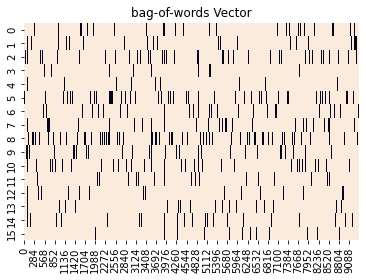

In [36]:
import seaborn as sns
sns.heatmap(description_vec.todense()==0, vmin=0, vmax=1, cbar=False).set_title('bag-of-words Vector')

In [37]:
# from wordcloud import WordCloud
# test_vec = description_vec[1].todense()
# col_names = np.array(text_vectorizer.get_feature_names())
# test = pd.DataFrame(test_vec, columns=col_names).T.to_dict()[0]
# print(test)
# word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
# plt.imshow(word_cloud)

interactive(children=(Dropdown(description='cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', '…

<function __main__.plot_explain_category(cat: str)>

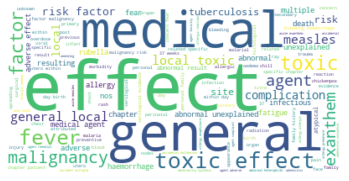

In [38]:
from wordcloud import WordCloud

# Explain a category

lookup = [x for _,x in sorted(zip(text_vectorizer.vocabulary_.values(), text_vectorizer.vocabulary_.keys()))]
features_arr = np.array(text_vectorizer.get_feature_names())

def explain_bow_vector(vec: scipy.sparse.csr.csr_matrix, ax=plt):
    # _, idxs = scipy.sparse.csr_matrix.nonzero(vec)
    # words = [lookup[k] for k in idxs]
    # word_cloud = WordCloud().generate(' '.join(words))
    test = pd.DataFrame(vec.todense(), columns=features_arr).T.to_dict()[0]
    word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")

def explain_category(cat:str, ax=plt):
    target = list(mult_lbl_enc.classes_).index(cat)
    target = description_vec[target]
    explain_bow_vector(target, ax=ax)

def plot_explain_category(cat:str):
    explain_category(cat)

interact(plot_explain_category, cat=mult_lbl_enc.classes_)

In [39]:
key = 'transcript__conversation_both'
# key = 'transcript__conversation_gp'
# key = 'transcript__conversation_patient'

X_train = text_vectorizer.transform(train_set[key])
X_test = text_vectorizer.transform(test_set[key])

Text(0.5, 1.0, 'Train set bag-of-words matrix')

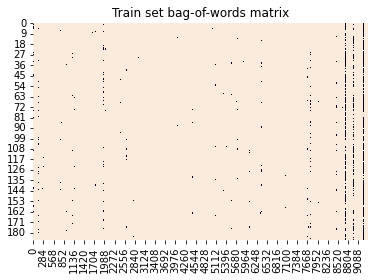

In [40]:
# import seaborn as sns
sns.heatmap(X_train.todense()==0, vmin=0, vmax=1, cbar=False).set_title('Train set bag-of-words matrix')

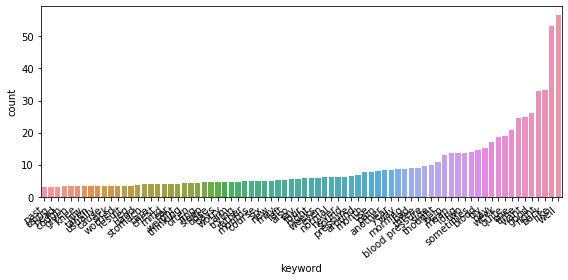

['past', 'using', 'head', 'cough', 'given', 'knee', 'low', 'taken', 'usually', 'cause', 'sick', 'worried', 'result', 'leg', 'hand', 'stomach', 'care', 'chest', 'mind', 'ear', 'weight', 'thinking', 'often', 'ring', 'sleep', 'dose', 'days', 'worry', 'arm', 'trying', 'rather', 'months', 'course', 'six', 'new', 'may', 'left', 'also', 'ray', 'four', 'night', 'weeks', 'even', 'normal', 'never', 'sound', 'pressure', 'around', 'month', 'use', 'pain', 'another', 'year', 'way', 'morning', 'bad', 'three', 'blood pressure', 'side', 'thought', 'help', 'mean', 'long', 'two', 'sometimes', 'blood', 'try', 'day', 'week', 'quite', 'one', 'time', 'want', 'good', 'right', 'back', 'like', 'well']


In [52]:
keyword_dist_over_train = np.array(X_train.sum(axis=0)).flatten()

def show_common_keywords(threshold:int = 3):
    frequent_words = [[k,n] for k,n in zip(lookup, keyword_dist_over_train) if n > threshold]
    frequent_words_df = pd.DataFrame(frequent_words,columns=['keyword', 'count']).sort_values('count')

    plt.figure(figsize=(8,4))
    ax = sns.barplot(x='keyword', y='count', data=frequent_words_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    print([k._text for k in ax.get_xticklabels()])

show_common_keywords()

### Nearest Centroid classifier

In [42]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
kn_clf.fit(description_vec, mult_lbl_enc.classes_)

nc_clf = NearestCentroid(metric='cosine')
nc_clf.fit(description_vec, mult_lbl_enc.classes_)

C:\Users\Vico\anaconda3\envs\NLP_GP\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


NearestCentroid(metric='cosine')

In [43]:
mult_lbl_enc.inverse_transform(y_train[0:1])

[('K', 'P')]

In [44]:
kn_clf.predict_proba(X_train[0:10])

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.32832135, 0.32628682, 0.        , 0.34539183, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.31882448, 0.        , 0.        , 0.        ,
        0.363134  , 0.        , 0.        , 0.31804152, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.3302447 , 0.        , 0.32899454, 0.34076076,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.34449274, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.32887825, 0.        ,
        0.        , 0.32662901, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.3424696 , 

In [45]:
kn_y_pred = kn_clf.predict(X_train)
y_pred = nc_clf.predict(X_train)

In [46]:
def get_idxes_with_cat(_y_train: np.ndarray, code:str):
    y_train_raw = mult_lbl_enc.inverse_transform(_y_train)
    return [i for i,cs in enumerate(y_train_raw) if code in cs]

def get_truth_pred_pairs(_y_train, _y_pred, indices):
    truth = mult_lbl_enc.inverse_transform(_y_train[indices])
    pred = _y_pred[indices]
    data = list(zip(indices, truth, pred))
    return pd.DataFrame(data, columns=['id', 'truth', 'predicted'])

def show_truth_pred_tbl(code):
    cat_idxes = get_idxes_with_cat(y_train, code)
    return get_truth_pred_pairs(y_train, y_pred, cat_idxes)

interact(show_truth_pred_tbl, code=mult_lbl_enc.classes_)

interactive(children=(Dropdown(description='code', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.show_truth_pred_tbl(code)>

Seems like the baseline is not performing well on predicting classes for:

A, F, N, S, T, W, X, Y

interactive(children=(Dropdown(description='_cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.view_record(_cat, _id)>

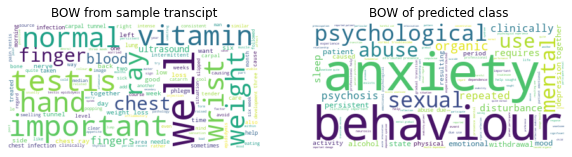

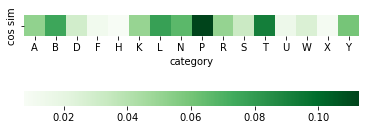

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

cat_dropdown = widgets.Dropdown(options=mult_lbl_enc.classes_)
id_dropdown = widgets.Dropdown(options=get_idxes_with_cat(y_train, cat_dropdown.value))

def refresh_id_dropdown(*args):
    id_dropdown.options = get_idxes_with_cat(y_train, cat_dropdown.value)

cat_dropdown.observe(refresh_id_dropdown, 'value')

def show_cosine_similarity(_id):
    cos_sim = cosine_similarity(X_train[_id], description_vec)[0]
    cos_sim = pd.DataFrame(list(zip(mult_lbl_enc.classes_, cos_sim)), columns=['category', 'cos sim'])
    cos_sim = cos_sim.set_index('category').T
    grid_kws = {"height_ratios": (.9, .05), "hspace": -0.5}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
    sns.heatmap(cos_sim, square=True, ax=ax,
                cbar_ax=cbar_ax,
                cbar_kws={"orientation": "horizontal"},
                cmap='Greens')

def show_keywords_true_pred(_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.title.set_text('BOW from sample transcipt')
    ax2.title.set_text('BOW of predicted class')
    explain_bow_vector(X_train[_id], ax=ax1)
    explain_category(y_pred[_id], ax=ax2)

def view_record(_cat, _id):
    global test
    record = train_set.iloc[_id]
    info = [f"Index: {_id}",
           f"Id: {record['record_id']}",
           f"Actual: {mult_lbl_enc.inverse_transform(y_train[_id:_id+1])}",
           f"Predicted: {y_pred[_id]}"]
    display(*info)
    show_keywords_true_pred(_id)
    show_cosine_similarity(_id)

interact(view_record, _cat=cat_dropdown, _id=id_dropdown)

In [48]:
y_train_mat = np.matrix(y_train)
y_pred_mat = np.matrix(mult_lbl_enc.transform(y_pred))


C:\Users\Vico\anaconda3\envs\NLP_GP\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vico\anaconda3\envs\NLP_GP\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vico\AppData\Local\Temp/ipykernel_20036/391074783.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


classification_report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        14
           B       0.45      0.83      0.59         6
           D       1.00      0.13      0.24        30
           F       0.25      0.33      0.29         3
           H       0.70      0.88      0.78         8
           K       0.43      0.45      0.44        22
           L       0.87      0.52      0.65        52
           N       0.33      0.10      0.15        10
           P       0.37      0.74      0.50        38
           R       0.86      0.44      0.59        27
           S       0.33      0.04      0.08        23
           T       0.75      0.21      0.33        14
           U       1.00      0.12      0.22        16
           W       0.00      0.00      0.00        10
           X       1.00      0.11      0.20         9
           Y       0.00      0.00      0.00         6

   micro avg       0.55      0.35      0.43       288
   

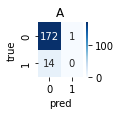

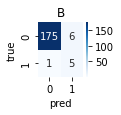

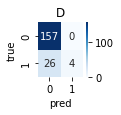

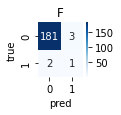

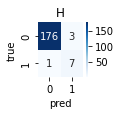

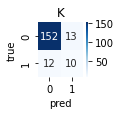

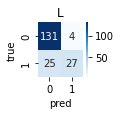

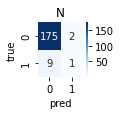

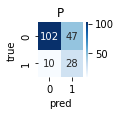

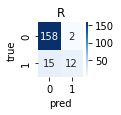

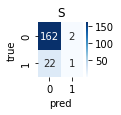

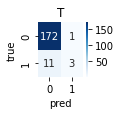

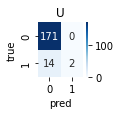

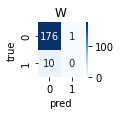

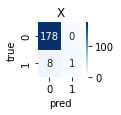

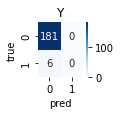

In [49]:
# Note: print statements does not work in PyCharm

from sklearn.metrics import accuracy_score, classification_report, f1_score, multilabel_confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

print(f"classification_report:\n{classification_report(y_train_mat, y_pred_mat, target_names=mult_lbl_enc.classes_)}")

print(f"multilabel_confusion_matrix:")
conf_mat = multilabel_confusion_matrix(y_train_mat, y_pred_mat)

for cls, mat in zip(mult_lbl_enc.classes_, conf_mat):
    fig = plt.figure(figsize=(1,1))
    ax = fig.add_subplot()
    ax.set_title(cls)
    sns.heatmap(mat, ax=ax, cmap='Blues', annot=True, fmt="d")
    ax.set_xlabel('pred')
    ax.set_ylabel('true')
    fig.show()

For `average` parameter to take the average metrics over all classes, please see [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel).

In [50]:

def show_result(average='weighted'):
    # measures the subset accuracy (only considered as accurate if the whole set matches)
    print(f"accuracy score: {accuracy_score(y_train_mat, y_pred_mat)}")

    print(f"f1_score: {f1_score(y_train_mat, y_pred_mat, average=average)}")

    print(f"precision_recall_fscore_support:\n{precision_recall_fscore_support(y_train_mat, y_pred_mat, average=average)}")

    print(f"roc_auc_score: {roc_auc_score(y_train_mat, y_pred_mat, average=average)}")

interact(show_result, average=['macro', 'weighted', 'micro', 'samples'])

interactive(children=(Dropdown(description='average', index=1, options=('macro', 'weighted', 'micro', 'samples…

<function __main__.show_result(average='weighted')>